<a href="https://colab.research.google.com/github/ruidongjr/IBM-Applied-Data-Science-Capstone/blob/main/Final_Project_The_Battle_of_Neighborhoods_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of Neighborhoods 


# 1. Introduction
## 1.1. Business Problem - Where is my dream cafe?

You want to run a cafe in San Francisco and you have got millions of ideas for the types of coffee beans and atmosphere that would make your cafe the best in the city. But you don't know much about what you have to do logistically to acquire or build a cafe. How can you figure out the best place in the city to start your dream bar?

That's what this project aims to figure out.

# 2. Data

## 2.1 [Crime data](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) in San Francisco

By analysing a list of every suburb in San Francisco, we can select one of the safer areas for a cafe.

## 2.2 [Business registration data](https://data.sfgov.org/Economy-and-Community/Registered-Business-Locations-San-Francisco/g8m3-pdis) in San Francisco

Competitors information can be gathered.

## 2.3 [Location map](https://foursquare.com/) for San Francisco via FourSquare

Foursquare data is robust and provides location data for Apple and Uber. Foursquare API allows you to retrieve information about the most popular spots in each neighborhood in San Francisco. This will be another good indication of foot traffic for particular venue types. Calling the Foursquare API returns a JSON file, which can be turned into a dataframe for analysis in python.




# 3. Methodology

In [3]:
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library


print('Libraries imported.')

Libraries imported.


## Read data

In [4]:
business = pd.read_csv('https://data.sfgov.org/api/views/g8m3-pdis/rows.csv?accessType=DOWNLOAD')
print(business.shape)
business.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(267360, 32)


,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,Location Start Date,Location End Date,Mail Address,Mail City,Mail Zipcode,Mail State,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location,UniqueID,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods
0,0031446-01-001,31446,Yong Kee Co Inc,Yong Kee Co Inc,732 Jackson St,San Francisco,CA,94133,05/31/2013,NaN,05/31/2013,NaN,20 Wayne Pl,San Francisco,94133,CA,5300-5399,Real Estate and Rental and Leasing Services,False,False,NaN,NaN,3.0,Chinatown,NaN,POINT (-122.40721 37.795982),0031446-01-001-0031446-5300-5399-05-31-2013,104.0,6.0,3.0,6.0,104.0
1,0051039-02-001,51039,Busuttel Joseph F,3615 19th St Apts,3615 19th St,San Francisco,CA,94110,10/01/1968,NaN,04/22/1977,NaN,505 Hazel Ave,San Bruno,94066,CA,5300-5399,Real Estate and Rental and Leasing Services,False,False,NaN,NaN,8.0,Mission,NaN,POINT (-122.423996 37.75992),0051039-02-001-0051039-5300-5399-04-22-1977,37.0,3.0,5.0,20.0,37.0
2,0078067-01-999,78067,R. S. Hughes Company Inc,Hughes R S Co Inc,7303 Edgewater Dr Oakland Unit B,Oakland,CA,94621,10/01/1968,NaN,10/01/1968,03/30/2014,1162 Sonora Ct,Sunnyvale,94086,CA,4200-4299,Wholesale Trade,False,False,NaN,NaN,NaN,NaN,NaN,POINT (-122.20762 37.74483),0078067-01-999-0078067-4200-4299-10-01-1968,NaN,NaN,NaN,NaN,NaN
3,0080538-01-001,80538,Kwang Chun Tsang & So Lan,333 31st Av Apts,333 31st Ave,San Francisco,CA,94121,07/20/1973,NaN,07/20/1973,NaN,530 Lower Vintners Cir,Fremont,94539,CA,5300-5399,Real Estate and Rental and Leasing Services,False,False,NaN,NaN,1.0,Outer Richmond,NaN,POINT (-122.491425 37.78295),0080538-01-001-0080538-5300-5399-07-20-1973,8.0,8.0,4.0,29.0,8.0
4,0095022-00-000,95022,"Graphics Etc, Inc.","Graphics Etc, Inc.",600 W Chicago Ave Suite 850,Chicago,IL,60654,01/01/1976,12/31/2012,01/01/1976,12/31/2012,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,POINT (-87.64443 41.898186),0095022-00-000-0095022--01-01-1976,NaN,NaN,NaN,NaN,NaN


In [5]:
#just pull the columns we need
business2 = business[['Business Start Date','DBA Name', 'Neighborhoods - Analysis Boundaries']].copy()

#drop null values
business3 = business2.dropna()

#convert business start date to datetime
business3['Business Start Date'] = business3['Business Start Date'].astype('datetime64[ns]') 

#let's just look at areas that have seen the most businesses start in the last decade.
business4 = business3.loc[business3['Business Start Date'] > '2010-01-01']

#let's also rename 'Neighborhoods - Analysis Boundaries' to just be 'Neighborhoods'
business4.rename(columns={'Neighborhoods - Analysis Boundaries': 'Neighborhood'}, inplace = True)

#let's do the same thing for the business name
business4.rename(columns={'DBA Name': 'Business Name'}, inplace = True)

business4.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Business Start Date,Business Name,Neighborhood
0,2013-05-31,Yong Kee Co Inc,Chinatown
18,2011-01-01,Vacation Rental,Sunset/Parkside
19,2011-08-20,Jim Oakley Mft,Hayes Valley
22,2011-04-01,Vision Academy Optometry,Bernal Heights
24,2013-05-07,Wall Road Vineyard Llc,Financial District/South Beach


In [6]:
#Count the number of businesses in each neighborhood by grouping the data
business5 = business4.groupby('Neighborhood', as_index=False).count()
business5.reset_index()
#let's get rid of the business start date, we won't be needing it anymore
business5.drop(columns = 'Business Start Date',inplace = True)
#rename our "business name" column to "Businesses" to reflect the count per neighborhood
business5.rename(columns={'Business Name': 'Businesses'}, inplace = True)
#and sort the data
business6 = business5.sort_values(by= ['Businesses'], ascending = False).head(10)
business6.reset_index(drop=True)
business6

,Neighborhood,Businesses
5,Financial District/South Beach,19818
18,Mission,10433
33,South of Market,8869
34,Sunset/Parkside,6078
0,Bayview Hunters Point,5813
16,Marina,4378
25,Outer Richmond,4113
35,Tenderloin,4112
2,Castro/Upper Market,3998
3,Chinatown,3911


In [7]:
#for reference, here is every neighborhood in SF as well as the count of registered businesses
business7 = business5.sort_values(by= ['Businesses'], ascending = False)
business7.reset_index(drop=True)
print(business7.shape)
business7

(41, 2)


,Neighborhood,Businesses
5,Financial District/South Beach,19818
18,Mission,10433
33,South of Market,8869
34,Sunset/Parkside,6078
0,Bayview Hunters Point,5813
16,Marina,4378
25,Outer Richmond,4113
35,Tenderloin,4112
2,Castro/Upper Market,3998
3,Chinatown,3911


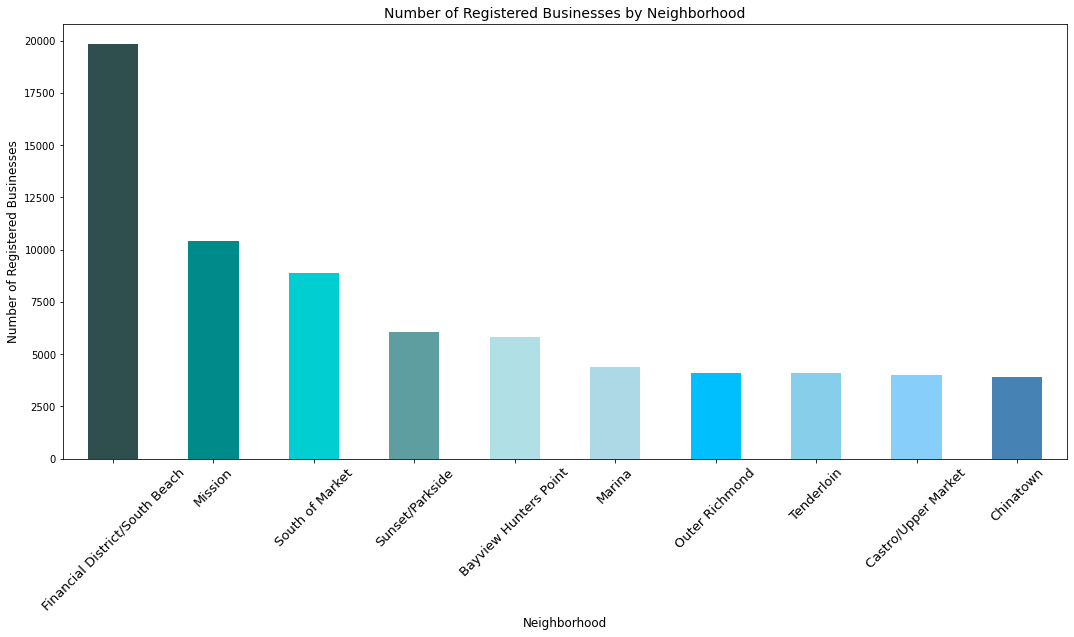

In [8]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


business6.plot.bar(x = 'Neighborhood', y = 'Businesses', title = "Number of Registered Businesses by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
plt.ylabel('Number of Registered Businesses', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Registered Businesses by Neighborhood', fontsize = 14)
plt.show()

It looks like the Financial District has the most businesses, but there are plenty of others that have lots of people working! Let's use the top 10 neighborhoods as our starting point.

Next, we want to make sure our cafe is in a safe part of town. So let's use San Francisco's crime data from the last 5 years to narrow down our list.

### Crime data

In [9]:
crime = pd.read_csv('https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD')
print(crime.shape)
crime.head()

(431134, 36)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites),ESNCAG - Boundary File,"Areas of Vulnerability, 2016"
0,2018/01/01 09:26:00 AM,2018/01/01,09:26,2018,Monday,2018/01/01 09:27:00 AM,61893007041,618930,171052174,173641140.0,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,03RD ST \ HOLLISTER AVE,20471000.0,Southern,Bayview Hunters Point,10.0,37.721716,-122.395944,"(37.72171587946975, -122.39594382884452)",88.0,2.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0
1,2018/01/01 02:30:00 AM,2018/01/01,02:30,2018,Monday,2018/01/01 08:21:00 AM,61893105041,618931,180000768,180010668.0,II,Initial,NaN,5041,Burglary,Burglary - Residential,"Burglary, Residence, Forcible Entry",Open or Active,LISBON ST \ PERSIA AVE,21719000.0,Ingleside,Excelsior,11.0,37.722000,-122.433606,"(37.722000219874225, -122.43360633930074)",90.0,9.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,2.0
2,2018/01/01 10:00:00 AM,2018/01/01,10:00,2018,Monday,2018/01/01 10:20:00 AM,61893275000,618932,180000605,180010893.0,IS,Initial Supplement,NaN,75000,Missing Person,Missing Person,Found Person,Open or Active,VAN NESS AVE \ WILLOW ST,25189000.0,Northern,Tenderloin,6.0,37.783370,-122.420832,"(37.78337048750076, -122.42083185184009)",20.0,4.0,10.0,36.0,NaN,NaN,1.0,NaN,NaN,2.0
3,2018/01/01 10:03:00 AM,2018/01/01,10:03,2018,Monday,2018/01/01 10:04:00 AM,61893565015,618935,180000887,180011579.0,II,Initial,NaN,65015,Other Miscellaneous,Other,"Driving, No License Issued",Cite or Arrest Adult,BRAZIL AVE \ MISSION ST,21769000.0,Ingleside,Outer Mission,11.0,37.724683,-122.434798,"(37.72468255342173, -122.43479841474401)",NaN,9.0,1.0,28.0,NaN,NaN,NaN,NaN,NaN,1.0
4,2018/01/01 09:01:00 AM,2018/01/01,09:01,2018,Monday,2018/01/01 09:39:00 AM,61893607041,618936,171052958,180011403.0,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,CUSTOM HOUSE PL \ JACKSON ST,24709000.0,Central,Chinatown,3.0,37.796698,-122.401294,"(37.796698028315056, -122.40129440446798)",106.0,6.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,2.0


In [10]:
#take just the columns we need
crime1 = crime[['Analysis Neighborhood','Incident Category', 'Incident Date']]

#drop all null values
crime2 = crime1.dropna()

#convert incident date to datetime
crime2['Incident Date'] = crime2['Incident Date'].astype('datetime64[ns]') 

#filter to just crimes in the last 5 years, as the neighborhoods in san francisco are rapidly changing and being gentrified, we want data that is relevant to today's crime.
crime3 = crime2.loc[crime2['Incident Date'] > '2015-01-01']

#There's lots of scary crimes out there, but let's make sure we aren't factoring in non-criminal police reports, because that data will pollute our insights.
crime4 = crime3.loc[crime3['Incident Category'] != 'Non-Criminal']

#change the name of 'Analysis Neighborhood' to 'Neighborhood'
crime4.rename(columns={'Analysis Neighborhood': 'Neighborhood'}, inplace = True)

crime4.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Incident Category,Incident Date
0,Bayview Hunters Point,Recovered Vehicle,2018-01-01
1,Excelsior,Burglary,2018-01-01
2,Tenderloin,Missing Person,2018-01-01
3,Outer Mission,Other Miscellaneous,2018-01-01
4,Chinatown,Recovered Vehicle,2018-01-01
5,Financial District/South Beach,Assault,2018-01-01
7,South of Market,Larceny Theft,2018-01-01
8,Oceanview/Merced/Ingleside,Assault,2018-01-01
9,Lakeshore,Burglary,2018-01-01
10,Financial District/South Beach,Suspicious Occ,2018-01-01


In [11]:
#count the number of crimes in each neighborhood
crime5 = crime4.groupby('Neighborhood', as_index=False).count()
#get rid of Incident Date
crime5.drop(columns = 'Incident Date',inplace = True)
#rename our column to reflect the counts of incidents
crime5.rename(columns={'Incident Category': 'Incidents'}, inplace = True)
#and sort our values
crime6 = crime5.sort_values(by= ['Incidents'], ascending = False)
crime7 = crime6.head(10)
crime7

,Neighborhood,Incidents
18,Mission,42732
35,Tenderloin,38885
5,Financial District/South Beach,33413
33,South of Market,32120
0,Bayview Hunters Point,24023
40,Western Addition,12601
2,Castro/Upper Market,11848
22,North Beach,11532
20,Nob Hill,11205
34,Sunset/Parkside,11171


Let's have a look at our data graphically.

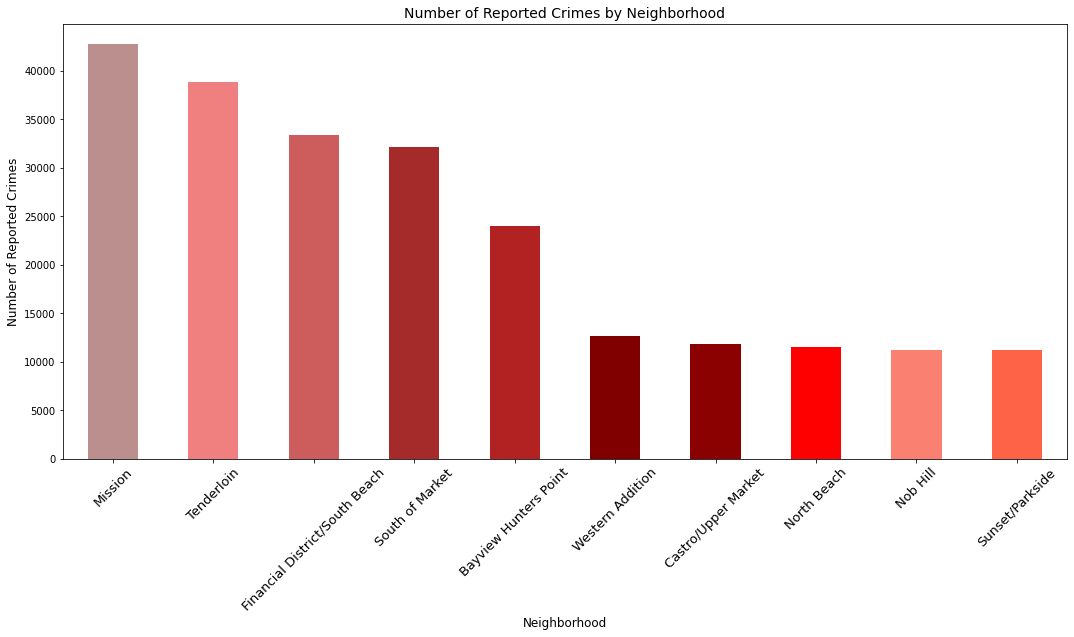

In [13]:
crime7.plot.bar(x = 'Neighborhood', y = 'Incidents', title = "Crime Incidents by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'salmon', 'tomato'])
plt.ylabel('Number of Reported Crimes', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Reported Crimes by Neighborhood', fontsize = 14)
plt.show()


It looks like there are 5 spots with heavy crime rates in San Francisco, and the rest seem on par with eachother.

Let's take our 10 favorite neighborhoods from before and sort out these 5 Neighborhoods with the highest crime rate.

In [14]:
#get a dataframe with the 5 highest incident neighborhoods
crime8 = crime7.head(5)
crime8

,Neighborhood,Incidents
18,Mission,42732
35,Tenderloin,38885
5,Financial District/South Beach,33413
33,South of Market,32120
0,Bayview Hunters Point,24023


In [15]:
'''start by merging the datasets and making a new dataset that incldues the neighborhoods 
which were among the top 10 for businesses AND are amond the top 5 for crime '''
Overlap = business6.merge(crime8, on=['Neighborhood'])
'''then take this joined dataframe and remove all common values from your list of top 10 
neighborhoods for businesses'''
SF_Neighborhoods = business6[(~business6.Neighborhood.isin(Overlap.Neighborhood))]
'''and what you have is the top neighborhoods for businesses that are NOT the top 
neighborhoods for crime'''
SF_Neighborhoods.head()

,Neighborhood,Businesses
34,Sunset/Parkside,6078
16,Marina,4378
25,Outer Richmond,4113
2,Castro/Upper Market,3998
3,Chinatown,3911


Now let's get the coordinates of each of our selected neighborhoods.



In [16]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_explorer")
SF_Neighborhoods['Coordinates'] = SF_Neighborhoods['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
SF_Neighborhoods

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,6078,"(42.75562315, -81.19147418031011)"
16,Marina,4378,"(43.5139149, 16.1092196)"
25,Outer Richmond,4113,"(44.108805, -69.798725)"
2,Castro/Upper Market,3998,"(37.767115, -122.4288861)"
3,Chinatown,3911,"(40.7164913, -73.9962504)"


It looks like geopy had them all over the place. Let's plug in values from Google Maps for the rest and clean up the coordinates a little.

In [17]:
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Sunset/Parkside' , 'Coordinates'] = "(37.751616, -122.490810)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Outer Richmond' , 'Coordinates'] = "(37.780001, -122.490229)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Castro/Upper Market' , 'Coordinates'] = "(37.762932, -122.435395)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Marina' , 'Coordinates'] = "(37.801406, -122.439718)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Chinatown' , 'Coordinates'] = "(37.7941, -122.4078)"
SF_Neighborhoods

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,6078,"(37.751616, -122.490810)"
16,Marina,4378,"(37.801406, -122.439718)"
25,Outer Richmond,4113,"(37.780001, -122.490229)"
2,Castro/Upper Market,3998,"(37.762932, -122.435395)"
3,Chinatown,3911,"(40.7164913, -73.9962504)"


### Merging Datasets
Now, we can add the Latitude and Longitude in separate columns and merge our datasets

In [39]:
SF = SF_Neighborhoods.merge(crime6, on=['Neighborhood'])
SF.rename(columns={'Incidents':'Crimes'}, inplace = True)
SF = SF[['Neighborhood', 'Businesses', 'Crimes','Coordinates']]
SF['Coordinates'].to_string()
SF[['Latitude','Longitude']] = SF['Coordinates'].str.strip('(').str.strip(')').str.split(', ', expand=True)

SF

,Neighborhood,Businesses,Crimes,Coordinates,Latitude,Longitude
0,Sunset/Parkside,6078,11171,"(37.751616, -122.490810)",37.751616,-122.490810
1,Marina,4378,10144,"(37.801406, -122.439718)",37.801406,-122.439718
2,Outer Richmond,4113,8717,"(37.780001, -122.490229)",37.780001,-122.490229
3,Castro/Upper Market,3998,11848,"(37.762932, -122.435395)",37.762932,-122.435395
4,Chinatown,3911,7083,"(40.7164913, -73.9962504)",40.7164913,-73.9962504


### Foursquare Data Analysis
Let's write a function to search the most popular venues within a .5 mile radius of our neighborhoods.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In order to use Foursquare API, we need to input our credentials


In [26]:
CLIENT_ID = 'xxx'
CLIENT_SECRET = 'xxx'
VERSION = '20210101'  # YYYYMMDD
LIMIT=10

In [40]:
SF_venues = getNearbyVenues(names=SF['Neighborhood'],
                                   latitudes=SF['Latitude'],
                                   longitudes=SF['Longitude']
                                  )

Sunset/Parkside
Marina
Outer Richmond
Castro/Upper Market
Chinatown


In [41]:
#Let's see the shape of our dataframe
print(SF_venues.shape)
SF_venues.head()

(50, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sunset/Parkside,37.751616,-122.490810,TJ Brewed Tea and Real Fruit (TJ Cups),37.753561,-122.490028,Bubble Tea Shop
1,Sunset/Parkside,37.751616,-122.490810,S&T Hong Kong Seafood,37.753702,-122.491278,Dim Sum Restaurant
2,Sunset/Parkside,37.751616,-122.490810,Donut Time,37.753651,-122.489439,Donut Shop
3,Sunset/Parkside,37.751616,-122.490810,Polly Ann Ice Cream,37.753454,-122.497765,Ice Cream Shop
4,Sunset/Parkside,37.751616,-122.490810,Sunset Recreation Center,37.757310,-122.487072,Playground


In [42]:
#take a look at how many venues were pulled for each neighborhood
SF_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Castro/Upper Market,10,10,10,10,10,10
Chinatown,10,10,10,10,10,10
Marina,10,10,10,10,10,10
Outer Richmond,10,10,10,10,10,10
Sunset/Parkside,10,10,10,10,10,10


In [43]:
#the number of unique types of venues pulled
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 36 uniques categories.


what are the most common venue categories in our 5 selected neighborhoods?



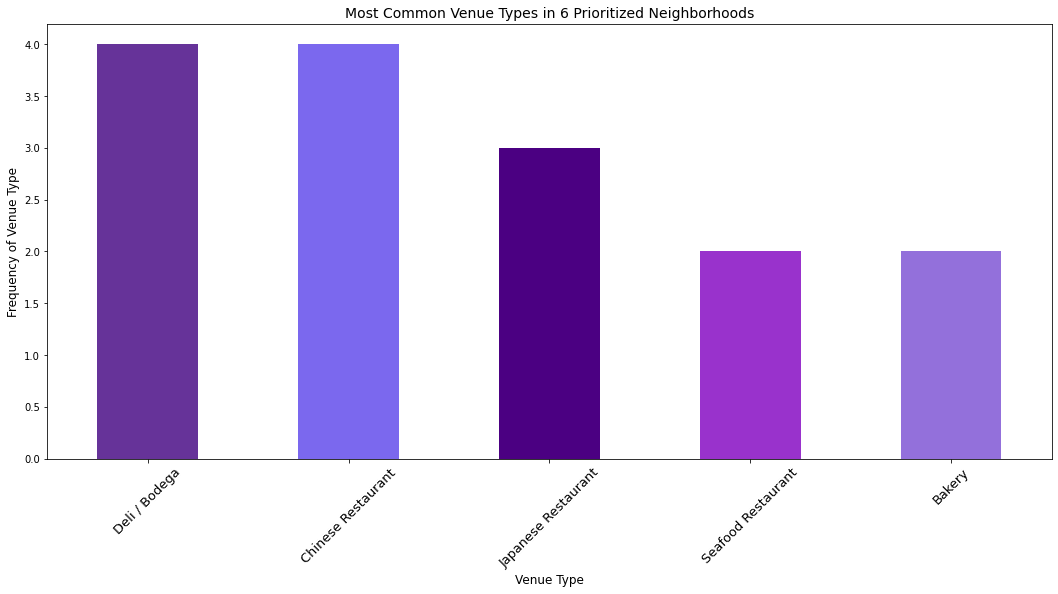

In [44]:
SF_top_venues = SF_venues.groupby('Venue Category', as_index = False).count().sort_values('Neighborhood', ascending = False).head(5)
SF_top_venues = SF_top_venues[['Venue Category','Neighborhood']]
SF_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
SF_top_venues.plot.bar(x='Venue Category', y='Frequency', legend = None, title = "Most common venue types in 6 prioritized neighborhoods", rot= 45, figsize = (18, 8), color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])
plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in 6 Prioritized Neighborhoods', fontsize = 14)
plt.show()

It looks like Deli shops are the most common venue type, followed by some restaurants, and finally bakery.

Let's do some one hot encoding to further analyze our results.

In [45]:
# one hot encoding
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SF_onehot['Neighborhood'] = SF_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

SF_onehot.head()

,Neighborhood,Arts & Crafts Store,Bakery,Bookstore,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Chinese Restaurant,Coffee Shop,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Donut Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Historic Site,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Optical Shop,Pizza Place,Playground,Salad Place,Seafood Restaurant,Snack Place,Spa,Trail,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Sunset/Parkside,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [46]:
#examine shape of new dataframe
SF_onehot.shape

(50, 37)

In [47]:
#now group the data
SF_grouped = SF_onehot.groupby('Neighborhood').mean().reset_index()
print(SF_grouped.shape)
SF_grouped

(5, 37)


,Neighborhood,Arts & Crafts Store,Bakery,Bookstore,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Chinese Restaurant,Coffee Shop,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Donut Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Historic Site,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Optical Shop,Pizza Place,Playground,Salad Place,Seafood Restaurant,Snack Place,Spa,Trail,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Castro/Upper Market,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1,Chinatown,0.0,0.1,0.0,0.0,0.0,0.0,0.2,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0
2,Marina,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0
3,Outer Richmond,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.2,0.0,0.0,0.1,0.0,0.0,0.0
4,Sunset/Parkside,0.0,0.0,0.0,0.1,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0


We can now see the frequency of the top 5 types of venues for each neighborhood.



In [48]:
#print each neighborhood with the top 5 most common venues
num_top_venues = 5

for hood in SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SF_grouped[SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Castro/Upper Market----
                     venue  freq
0              Yoga Studio   0.1
1                Bookstore   0.1
2      Indie Movie Theater   0.1
3             Burger Joint   0.1
4  New American Restaurant   0.1


----Chinatown----
                venue  freq
0  Chinese Restaurant   0.2
1               Hotel   0.1
2         Snack Place   0.1
3              Bakery   0.1
4        Optical Shop   0.1


----Marina----
                  venue  freq
0         Deli / Bodega   0.2
1           Salad Place   0.1
2   Japanese Restaurant   0.1
3  Gym / Fitness Center   0.1
4      Greek Restaurant   0.1


----Outer Richmond----
                 venue  freq
0   Seafood Restaurant   0.2
1   Italian Restaurant   0.1
2          Pizza Place   0.1
3  Japanese Restaurant   0.1
4    Korean Restaurant   0.1


----Sunset/Parkside----
                 venue  freq
0   Chinese Restaurant   0.2
1           Playground   0.2
2       Ice Cream Shop   0.1
3   Dim Sum Restaurant   0.1
4  Japanese Restaur

Now we can place our data into a dataframe of the most popular venues for each neighborhood.



In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SF_grouped['Neighborhood']

for ind in np.arange(SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Castro/Upper Market,Yoga Studio,New American Restaurant,Bakery,Bookstore,Burger Joint,Coffee Shop,Deli / Bodega,Gym / Fitness Center,Indie Movie Theater,Historic Site,Optical Shop,Pizza Place,Vietnamese Restaurant,Trail,Bubble Tea Shop,Spa,Burmese Restaurant,Chinese Restaurant,Snack Place,Cosmetics Shop,Cupcake Shop,Seafood Restaurant,Dessert Shop,Dim Sum Restaurant,Donut Shop,Greek Restaurant,Grocery Store,Salad Place,Wine Bar,Hotel
1,Chinatown,Chinese Restaurant,Optical Shop,Cosmetics Shop,Bakery,Spa,Snack Place,Hotel,Ice Cream Shop,Dessert Shop,Dim Sum Restaurant,Deli / Bodega,Cupcake Shop,Yoga Studio,Coffee Shop,Greek Restaurant,Burmese Restaurant,Burger Joint,Bubble Tea Shop,Bookstore,Donut Shop,Historic Site,Grocery Store,Gym / Fitness Center,Wine Bar,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Pizza Place
2,Marina,Deli / Bodega,Arts & Crafts Store,Pizza Place,Wine Bar,Japanese Restaurant,Cupcake Shop,Greek Restaurant,Gym / Fitness Center,Salad Place,Chinese Restaurant,Burmese Restaurant,Cosmetics Shop,Burger Joint,Bubble Tea Shop,Bookstore,Dessert Shop,Dim Sum Restaurant,Donut Shop,Bakery,Coffee Shop,Yoga Studio,Grocery Store,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Korean Restaurant,New American Restaurant,Optical Shop,Playground
3,Outer Richmond,Seafood Restaurant,Grocery Store,Japanese Restaurant,Trail,Deli / Bodega,Burmese Restaurant,Pizza Place,Italian Restaurant,Korean Restaurant,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Cosmetics Shop,Yoga Studio,Coffee Shop,Donut Shop,Burger Joint,Bubble Tea Shop,Bookstore,Bakery,Chinese Restaurant,Historic Site,Greek Restaurant,Gym / Fitness Center,Wine Bar,Hotel,Ice Cream Shop,Indie Movie Theater,New American Restaurant,Optical Shop
4,Sunset/Parkside,Playground,Chinese Restaurant,Vietnamese Restaurant,Donut Shop,Dim Sum Restaurant,Bubble Tea Shop,Ice Cream Shop,Japanese Restaurant,Yoga Studio,Cupcake Shop,Dessert Shop,Deli / Bodega,Coffee Shop,Cosmetics Shop,Grocery Store,Burmese Restaurant,Burger Joint,Bookstore,Bakery,Greek Restaurant,Historic Site,Gym / Fitness Center,Wine Bar,Hotel,Indie Movie Theater,Italian Restaurant,Korean Restaurant,New American Restaurant,Optical Shop,Pizza Place


## Clustering
Let's use K means clustering to cluster our neighborhoods for more insights!

In [51]:
# set number of clusters
kclusters = 3

SF_grouped_clustering = SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 0, 0, 1], dtype=int32)

Now create a dataframe that includes the cluster as well as the top 10 venues for each neighborhood



In [52]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

SF_merged = SF.copy()

In [53]:
# merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
SF_merged = SF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [59]:
#also including the number of bars and restaurants that each neighborhood has in its top 10 most popular spots.
SF_merged["Bars and Restaurants"] = ""
SF_merged.loc[SF_merged.Neighborhood == 'Sunset/Parkside', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'Outer Richmond', 'Bars and Restaurants'] = .6
SF_merged.loc[SF_merged.Neighborhood == 'Marina', 'Bars and Restaurants'] = .67
SF_merged.loc[SF_merged.Neighborhood == 'Castro/Upper Market', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'Chinatown', 'Bars and Restaurants'] = .5
SF_merged['Bars and Restaurants']

0    0.37
1    0.67
2     0.6
3    0.37
4     0.5
Name: Bars and Restaurants, dtype: object

In [60]:
SF_merged['Latitude'] = SF_merged['Latitude'].astype(float)
SF_merged['Longitude'] = SF_merged['Longitude'].astype(float)
SF_merged['Cluster Labels'] = SF_merged['Cluster Labels'].astype(int)



SF_merged

,Neighborhood,Businesses,Crimes,Coordinates,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Bars and Restaurants
0,Sunset/Parkside,6078,11171,"(37.751616, -122.490810)",37.751616,-122.490810,1,Playground,Chinese Restaurant,Vietnamese Restaurant,Donut Shop,Dim Sum Restaurant,Bubble Tea Shop,Ice Cream Shop,Japanese Restaurant,Yoga Studio,Cupcake Shop,Dessert Shop,Deli / Bodega,Coffee Shop,Cosmetics Shop,Grocery Store,Burmese Restaurant,Burger Joint,Bookstore,Bakery,Greek Restaurant,Historic Site,Gym / Fitness Center,Wine Bar,Hotel,Indie Movie Theater,Italian Restaurant,Korean Restaurant,New American Restaurant,Optical Shop,Pizza Place,0.37
1,Marina,4378,10144,"(37.801406, -122.439718)",37.801406,-122.439718,0,Deli / Bodega,Arts & Crafts Store,Pizza Place,Wine Bar,Japanese Restaurant,Cupcake Shop,Greek Restaurant,Gym / Fitness Center,Salad Place,Chinese Restaurant,Burmese Restaurant,Cosmetics Shop,Burger Joint,Bubble Tea Shop,Bookstore,Dessert Shop,Dim Sum Restaurant,Donut Shop,Bakery,Coffee Shop,Yoga Studio,Grocery Store,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Korean Restaurant,New American Restaurant,Optical Shop,Playground,0.67
2,Outer Richmond,4113,8717,"(37.780001, -122.490229)",37.780001,-122.490229,0,Seafood Restaurant,Grocery Store,Japanese Restaurant,Trail,Deli / Bodega,Burmese Restaurant,Pizza Place,Italian Restaurant,Korean Restaurant,Dim Sum Restaurant,Dessert Shop,Cupcake Shop,Cosmetics Shop,Yoga Studio,Coffee Shop,Donut Shop,Burger Joint,Bubble Tea Shop,Bookstore,Bakery,Chinese Restaurant,Historic Site,Greek Restaurant,Gym / Fitness Center,Wine Bar,Hotel,Ice Cream Shop,Indie Movie Theater,New American Restaurant,Optical Shop,0.6
3,Castro/Upper Market,3998,11848,"(37.762932, -122.435395)",37.762932,-122.435395,2,Yoga Studio,New American Restaurant,Bakery,Bookstore,Burger Joint,Coffee Shop,Deli / Bodega,Gym / Fitness Center,Indie Movie Theater,Historic Site,Optical Shop,Pizza Place,Vietnamese Restaurant,Trail,Bubble Tea Shop,Spa,Burmese Restaurant,Chinese Restaurant,Snack Place,Cosmetics Shop,Cupcake Shop,Seafood Restaurant,Dessert Shop,Dim Sum Restaurant,Donut Shop,Greek Restaurant,Grocery Store,Salad Place,Wine Bar,Hotel,0.37
4,Chinatown,3911,7083,"(40.7164913, -73.9962504)",40.716491,-73.996250,1,Chinese Restaurant,Optical Shop,Cosmetics Shop,Bakery,Spa,Snack Place,Hotel,Ice Cream Shop,Dessert Shop,Dim Sum Restaurant,Deli / Bodega,Cupcake Shop,Yoga Studio,Coffee Shop,Greek Restaurant,Burmese Restaurant,Burger Joint,Bubble Tea Shop,Bookstore,Donut Shop,Historic Site,Grocery Store,Gym / Fitness Center,Wine Bar,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Pizza Place,0.5


Let's visualize the percentage of pupular venues in each neighborhood that are bars or restaurants. this will help us see which neighborhoods are more popular BECAUSE of their bar and restuaraunt scene, and which are popular for other reasons.

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


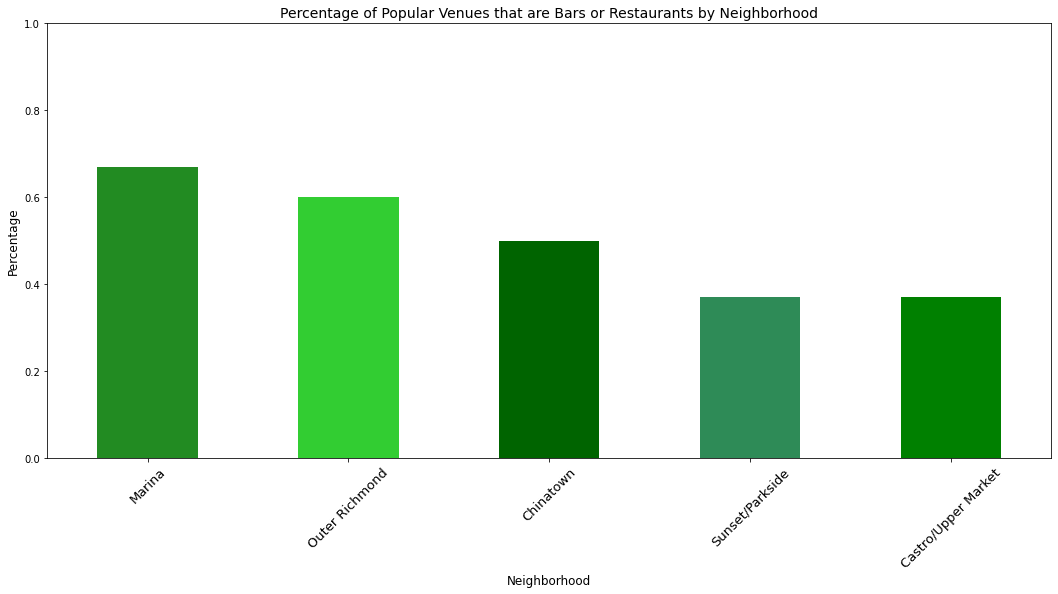

In [61]:

SF_rb = SF_merged[['Neighborhood','Bars and Restaurants']]
SF_rb.rename(columns={'Bars and Restaurants': 'Frequency'}, inplace = True)
SF_rb.sort_values('Frequency', inplace = True, ascending = False)
SF_rb.plot.bar(x='Neighborhood',y ='Frequency', rot = 45, figsize = (18, 8), legend = None, color = ['forestgreen','limegreen','darkgreen','seagreen','green','mediumseagreen'])
plt.ylabel('Percentage', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylim(0,1)
plt.title('Percentage of Popular Venues that are Bars or Restaurants by Neighborhood', fontsize = 14)
plt.show()

### Map Clustered Neighborhoods¶
Next, let's pull the coordinates for San Francisco and build a map.

In [62]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="SF_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


Finally, let's map our clustered neighborhoods to see which ones are more similar.



In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(.7, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
markers_colors = []
for lat, lon, poi, cluster, bars in zip(SF_merged['Latitude'], SF_merged['Longitude'], SF_merged['Neighborhood'], SF_merged['Cluster Labels'], SF_merged['Bars and Restaurants']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=35*bars,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# 3. Results and Discussion
We have pulled data on crime rates and business registrations for every neighborhood in San Francisco and used this information to narrow down our neighborhood options to 5 neighborhoods. Our analysis has informed us that:

* Deli/Bodega, Chinese restaurant, Japanese restaurant, seafood restaurant, and bakery are the most common venues in our 5 preferred neighborhoods.


* Clustering neighborhoods based on their most popular venues grouped Chinatown with Sunset/Parkside into a cluster, Outer Richmond and Marina into another cluster, and Castro/Upper Market as its own independent cluster.


* Chinatown, Sunset, Marina, and Outer Richmond have majority restaurants, deli shops as popular venues, whereas most of the popular venues in Castro are not bars or restaurants, but locations like parks and yoga studios.

* A major drawback of this analysis is that the clustering was completely based on Foursquare’ s data for popular venues. There are plenty other ways to assess popularity of neighborhoods and the spots inside them, venue popularity is just one of them. It may also be helpful to look exclusively at bars in an area, how many there are, and how popular they are on weekdays and weekends.

### **Based on above analysis, Castro seems to offer a good balance between foot traffic, popularity for cafes, and cafe scarsity. **


# 4. Conclusion
Finally, we have executed an end-to-end data science project using common python libraries to manipulate data sets, Foursquare API to explore the neighborhoods of San Francisco, and Folium leaflet map to cluster and segment neighborhoods. This was just one use-case. These analytical tools open a world of possibilities for strategic decision making across the various realms of business: from healthcare to real estate to energy. All you need is a little curiosity and the desire to learn!